# Inspect the data

In [1]:
# 读取 data/train_data_ts.tsv中的数据
# 读取 data/test_data_ts.tsv中的数据
# 其中，每一行的数据形如 <label, d1, d2, d3, . . . , d2000>，d1 − d2000 表示一个维度为 2000 的序列，label 是这个序列的标签 (类别)。

train = 'data/train_data_ts.tsv'
test = 'data/test_data_ts.tsv'
train_large = 'data_large/train_data.tsv'
test_large = 'data_large/test_data.tsv'

def read_data(file):
    data = []
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split('\t')
            data.append(line)
    return data

train_data = read_data(train)
test_data = read_data(test)
train_data_large = read_data(train_large)
test_data_large = read_data(test_large)

len(train_data[0]), len(test_data[0]), len(train_data_large[0]), len(test_data_large[0]), len(train_data), len(test_data), len(train_data_large), len(test_data_large)

(344, 344, 2001, 2001, 33, 130, 104, 208)

total labels: 52


/var/folders/wz/4cyv558d01jb0_wb8_71vmz00000gn/T/ipykernel_12843/659559927.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


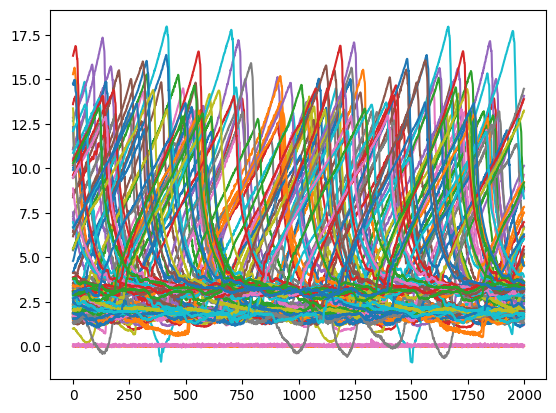

total labels: 52


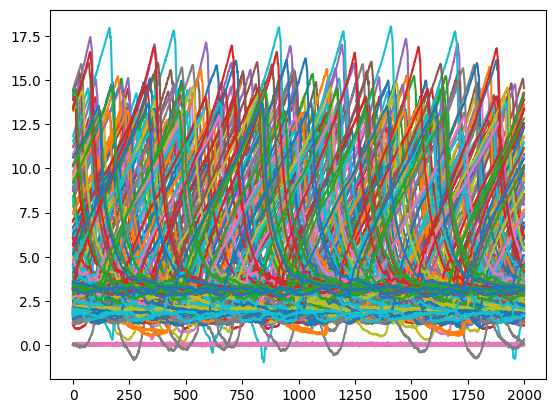

In [11]:
# 可视化：选取一个时间序列arr, 将arr[1:]作为y轴，arr[0]作为label，绘制折线图
# 一样的标签用一样的颜色画，不同的标签用不同的颜色画
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data):
    unique_labels = list(set(arr[0] for arr in data))
    print(f"total labels: {len(unique_labels)}")
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    # Plot each time series with the corresponding color
    for arr in data:
        label = arr[0]
        ts = np.array(arr[1:]).astype(float)
        color = colors(unique_labels.index(label))
        plt.plot(ts, color=color)

    # plt.legend(unique_labels, loc='right')
    plt.show()

plot_data(train_data_large)
plot_data(test_data_large)

# DTW algorithm

In [ ]:
import numpy as np
import time

def dp(signal1, signal2, window_size, dst_criterion):
    if dst_criterion == 'abs':
        dst_mat = np.abs(signal1[:, np.newaxis] - signal2)
    else:
        raise ValueError('Invalid distance criterion')

    M, N = len(signal1), len(signal2)
    cost_mat = np.full((M, N), np.inf)  # 代价矩阵
    window_size = max(window_size, abs(M - N))  # 窗口大小至少为两个序列长度之差

    # 初始化起始点
    cost_mat[0, 0] = dst_mat[0, 0]
    
    # 填充代价矩阵，同时使用窗口限制
    for i in range(M):
        for j in range(max(0, i - window_size), min(N, i + window_size + 1)):
            if i == 0 and j == 0:
                continue
            # 考虑从左上、上、左移动到当前位置的成本
            min_cost = min(
                cost_mat[i-1, j-1] if i > 0 and j > 0 else np.inf,
                cost_mat[i-1, j] if i > 0 else np.inf,
                cost_mat[i, j-1] if j > 0 else np.inf
            )
            cost_mat[i, j] = dst_mat[i, j] + min_cost
    return cost_mat

def backtrack(cost_mat, window_size):
    M, N = cost_mat.shape
    i, j = M-1, N-1
    path = [(i, j)]
    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            # 只考虑在窗口范围内的三个方向
            go_direction = np.argmin([
                cost_mat[i-1, j-1] if i > 0 and j > 0 else np.inf,
                cost_mat[i-1, j] if i > 0 else np.inf,
                cost_mat[i, j-1] if j > 0 else np.inf
            ])
            if go_direction == 0:
                i -= 1
                j -= 1
            elif go_direction == 1:
                i -= 1
            else:
                j -= 1
        path.append((i, j))
    total_cost = np.sum([cost_mat[i, j] for i, j in path])
    return path[::-1], total_cost

"""def dtw(signal1, signal2, window_size=1, dst_criterion='abs'):
    cost_mat = dp(signal1, signal2, window_size, dst_criterion)
    path, total_cost = backtrack(cost_mat, window_size)
    return path, total_cost"""

def dtw(signal1, signal2, window_size=1, dst_criterion='abs'):
    cost_mat = dp(signal1, signal2, window_size, dst_criterion)
    return cost_mat[-1,-1]

# 示例调用
window_size=5
signal1 = np.array([1,1,3,3,2,4])
signal2 = np.array([1,3,2,2,4,4])
cost_mat = dp(signal1, signal2, window_size, dst_criterion='abs')
print(cost_mat)
path, total_cost = backtrack(cost_mat, window_size)
print(path)
print(total_cost)


[[ 0.  0.  2.  4.  5.  8.]
 [ 2.  2.  0.  0.  1.  2.]
 [ 3.  3.  1.  1.  0.  2.]
 [ 4.  4.  2.  2.  0.  2.]
 [ 7.  7.  3.  3.  2.  0.]
 [10. 10.  4.  4.  4.  0.]]
[(0, 0), (1, 0), (2, 1), (3, 1), (4, 2), (4, 3), (5, 4), (5, 5)]
0.0


In [9]:
def aggr_dtw(signal1, signal_list, window_size, dst_criterion):
    cost_list = []
    for signal2 in signal_list:
        total_cost = dtw(signal1, signal2, window_size, dst_criterion)
        cost_list.append(total_cost)
    aggr_dtw_val = np.mean(cost_list)
    return aggr_dtw_val

signal1 = np.array([1,2,3,4,5,6])
signal2 = [np.array([1,2,3,4,5,6]),np.array([1,2,3,4,5,5]),np.array([1,2,3,4,5,6,7])]
window_size = 1
dst_criterion = 'abs'
print(aggr_dtw(signal1, signal2, window_size, dst_criterion))
print(dtw(signal1, signal2[0], window_size, dst_criterion))
print(dtw(signal1, signal2[1], window_size, dst_criterion))
print(dtw(signal1, signal2[2], window_size, dst_criterion))

0.6666666666666666
0.0
1.0
1.0


In [3]:
def cluster_train_data(train_data):
    train_data_dict = {}
    for arr in train_data:
        label = arr[0]
        ts = np.array(arr[1:]).astype(float)
        if label not in train_data_dict:
            train_data_dict[label] = []
        train_data_dict[label].append(ts)
    return train_data_dict

def predict(train_data, test_data, window_size, dst_criterion):
    """
        return prediction accuracy
    """
    train_data_dict = cluster_train_data(train_data)
    acc_num = 0
    for arr in test_data:
        start_time = time.time()
        label = arr[0]
        test_X = np.array(arr[1:]).astype(float)
        label_score = []

        for train_label, train_X_list in train_data_dict.items():
           
            aggr_dtw_val = aggr_dtw(test_X, train_X_list, window_size, dst_criterion)
            label_score.append((train_label, aggr_dtw_val))
        pred_label = min(label_score, key=lambda x: x[1])[0]
        if pred_label == label:
            acc_num += 1
        print(f"Time elapsed for one prediction: {round(time.time() - start_time, 2)}s")
    return acc_num / len(test_data)

#acc = predict(train_data, test_data, window_size=len(train_data[0]), dst_criterion='abs')
#acc

In [4]:
cluster_train_data(train_data_large)

{'1': [array([3.710937, 3.701782, 3.710937, ..., 1.998901, 1.950073, 1.950073]),
  array([1.681519 , 1.675415 , 1.6357419, ..., 1.187134 , 1.2146   ,
         1.208496 ])],
 '2': [array([0.      , 0.030518, 0.021362, ..., 0.033569, 0.      , 0.009155]),
  array([ 0.015259, -0.003052,  0.021362, ..., -0.012207, -0.009155,
          0.006104])],
 '3': [array([13.607788 , 13.705444 , 13.723755 , ...,  6.1065669,  6.137085 ,
          6.1737061]),
  array([1.763916 , 1.77002  , 1.760864 , ..., 2.719116 , 2.7130129,
         2.645874 ])],
 '4': [array([0.99487299, 1.000977  , 1.022339  , ..., 1.8218991 , 1.815796  ,
         1.791382  ]),
  array([1.858521, 1.849365, 1.89209 , ..., 1.947021, 1.904297, 1.913452])],
 '5': [array([2.3956299, 2.4108889, 2.3803711, ..., 2.9144289, 2.9144289,
         2.850342 ]),
  array([12.661743 , 12.67395  , 12.698364 , ...,  1.998901 ,  2.0050049,
          2.038574 ])],
 '6': [array([10.177612 , 10.195923 , 10.214233 , ...,  2.0050049,  2.0263669,
        

In [10]:
cluster_train_data(test_data_large)

{'1': [array([1.950073 , 1.913452 , 1.8737791, ..., 1.409912 , 1.373291 ,
         1.339722 ]),
  array([1.28479 , 1.290894, 1.290894, ..., 2.246094, 2.230835, 2.337646]),
  array([1.208496 , 1.18103  , 1.1962889, ..., 1.940918 , 1.8768311,
         1.855469 ]),
  array([ 1.831055,  1.852417,  1.794434, ..., 13.876343, 13.946533,
         13.928223])],
 '2': [array([ 0.009155,  0.018311, -0.006104, ...,  0.012207,  0.024414,
          0.009155]),
  array([ 0.021362,  0.045776,  0.003052, ..., -0.009155, -0.003052,
          0.015259]),
  array([ 0.006104,  0.021362,  0.      , ..., -0.003052,  0.009155,
         -0.003052]),
  array([-0.006104, -0.009155, -0.012207, ...,  0.018311,  0.018311,
          0.003052])],
 '3': [array([6.1737061, 6.2164311, 6.268311 , ..., 1.12915  , 1.1444089,
         1.104736 ]),
  array([1.1413569, 1.113892 , 1.071167 , ..., 1.559448 , 1.495361 ,
         1.5350339]),
  array([ 2.645874 ,  2.5878911,  2.5848391, ..., 10.037231 , 10.061646 ,
         10.11